In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.DAS import DAS, DAS_dual
from models.PACT import PSF_PACT, TF_PACT
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import *
from utils.simulations import get_water_SoS
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load Sinogram

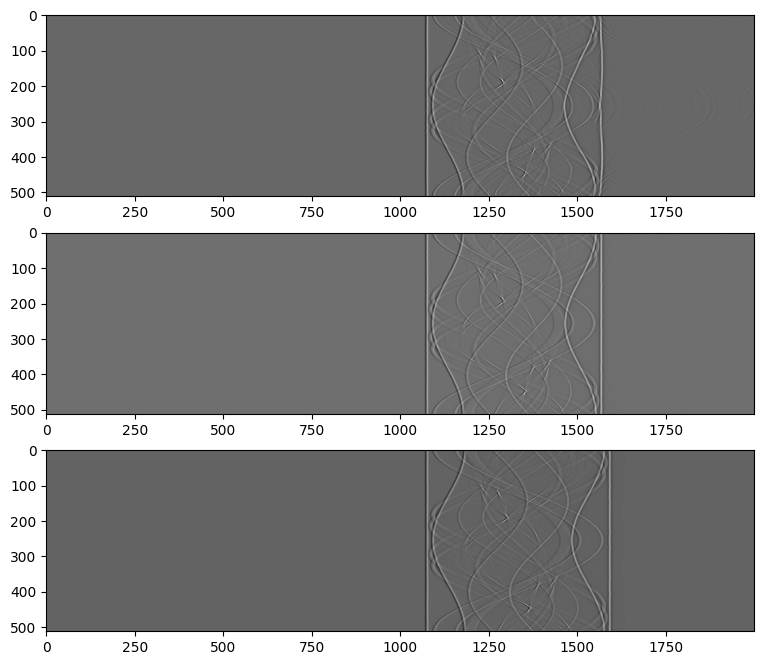

In [2]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)
sinogram_sb = load_mat(os.path.join(data_path, 'sinogram_simulation_sb.mat'))
sinogram_sb += np.random.normal(0, 1e-4, sinogram_sb.shape)
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
# sinogram_uniform += np.random.normal(0, 1e-4, sinogram_uniform.shape)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(3,1,2)
plt.imshow(sinogram_sb, cmap='gray')
plt.subplot(3,1,3)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Preparations

First, we need to define the size and resolution of the image. We also calculate the X and Y coordinates of each pixels in the image.

In [3]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Next, we define parameters of the single-body SoS for the following wavefront and PSF calculations.

In [4]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


Calculate the gaussian kernel which smooths the image boundaries when merging image patches.

In [5]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

Initialize the delay-and-sum model.

In [6]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

DAS()

### Uniform SoS

In [7]:
with torch.no_grad():
    gt = das(sinogram=torch.tensor(sinogram_uniform, device=device), 
             v0=torch.tensor(v0, device=device),
             d_delay=torch.zeros(1, device=device),
             ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [8]:
save_mat(os.path.join(results_path, 'gt_simulation.mat'), gt.swapaxes(0,1), 'img')

### Conventional DAS

In [9]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram, device=device),
                  v0=torch.tensor(1513.5, device=device),
                  d_delay=torch.zeros(1, device=device),
                  ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()
    rec_das_sb = das(sinogram=torch.tensor(sinogram_sb, device=device),
                     v0=torch.tensor(1513.5, device=device),
                     d_delay=torch.zeros(1, device=device),
                     ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

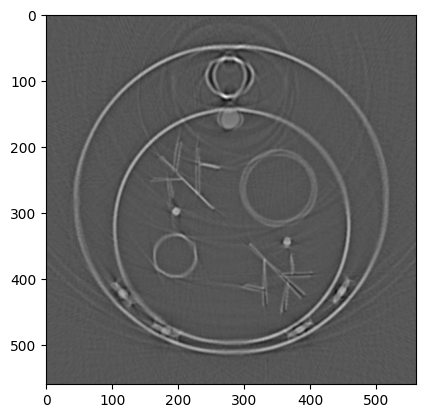

In [10]:
plt.imshow(rec_das, cmap='gray')

In [11]:
save_mat(os.path.join(results_path, 'das_simulation.mat'), rec_das.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_simulation_sb.mat'), rec_das_sb.swapaxes(0,1), 'img')

### Dual SoS DAS

In [12]:
das_dual = DAS_dual(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, R_body=R, center=(0.0, 0.0), mode='zero', device=device)
das_dual.to(device)
das_dual.eval()

DAS_dual()

In [13]:
with torch.no_grad():
    rec_das_dual = das_dual(sinogram=torch.tensor(sinogram, device=device),
                            v0=torch.tensor(v0, device=device),
                            v1=torch.tensor(v1, device=device),
                            d_delay=torch.zeros(1, device=device), 
                            ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()
    rec_das_dual_sb = das_dual(sinogram=torch.tensor(sinogram_sb, device=device),
                               v0=torch.tensor(v0, device=device),
                               v1=torch.tensor(v1, device=device),
                               d_delay=torch.zeros(1, device=device),
                               ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [14]:
save_mat(os.path.join(results_path, 'das_dual_simulation.mat'), rec_das_dual.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_dual_simulation_sb.mat'), rec_das_dual_sb.swapaxes(0,1), 'img')

### APACT

In [15]:
# delays_apact = np.arange(-8e-4, 8e-4, 0.5e-4) # Delay distances [m].

# apact = APACT(delays=delays_apact, dc_range=[-2e-4, 1.6e-4], amp=3.2e-4, step=4e-5, data_path='./TF_simulation/', device=device)
# apact.to(device)
# apact.eval()

In [16]:
# img_stack = []
# with torch.no_grad():
#     for d_delay in tqdm(delays_apact):
#         recon = das(sinogram=torch.tensor(sinogram, device=device), 
#                     v0=torch.tensor(1513.5, device=device),
#                     d_delay=torch.tensor(d_delay, device=device),
#                     ring_error=torch.zeros(1, device=device))
#         img_stack.append(recon)
# img_stack = torch.stack(img_stack, dim=0)

# img_stack_sb = []
# with torch.no_grad():
#     for d_delay in tqdm(delays_apact):
#         recon_sb = das(sinogram=torch.tensor(sinogram_sb, device=device),
#                        v0=torch.tensor(1513.5, device=device),
#                        d_delay=torch.tensor(d_delay, device=device),
#                        ring_error=torch.zeros(1, device=device))
#         img_stack_sb.append(recon_sb)
# img_stack_sb = torch.stack(img_stack_sb, dim=0)

In [17]:
# def deconv_full_apact(model, img_stack, gaussian_window):
#     rec_apact = torch.zeros_like(img_stack[0], device=device)
#     with torch.no_grad():
#         for idx in tqdm(range(625)):
#             i, j = idx // 25, idx % 25
#             obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
#             obs = obs.unsqueeze(0).to(device)
#             rec, _, _, _ = model(obs)
#             rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
#     return rec_apact.detach().cpu().numpy()

# rec_apact = deconv_full_apact(apact, img_stack, gaussian_window)
# rec_apact_sb = deconv_full_apact(apact, img_stack_sb, gaussian_window)

In [18]:
# save_mat(os.path.join(results_path, 'apact_simulation.mat'), rec_apact.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'apact_simulation_sb.mat'), rec_apact_sb.swapaxes(0,1), 'img')

### Deconvolution with Single Body PSFs

In [19]:
n_delays = 32
# delays = get_delays(R, v0, v1, n_delays, 'uniform')
# delays = np.arange(-8e-4, 8e-4, 0.5e-4)
delays = np.linspace(-8e-4, 8e-4, n_delays)

In [20]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon = das(sinogram=torch.tensor(sinogram, device=device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

img_stack_sb = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon_sb = das(sinogram=torch.tensor(sinogram_sb, device=device),
                       v0=torch.tensor(v0, device=device),
                       d_delay=torch.tensor(d_delay, device=device),
                       ring_error=torch.zeros(1, device=device))
        img_stack_sb.append(recon_sb)
img_stack_sb = torch.stack(img_stack_sb, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.98it/s]


In [21]:
psf_pact = PSF_PACT(n_points=80, l=l, n_delays=delays.shape[0], device=device)
psf_pact.to(device)
psf_pact.eval()

tf_pact = TF_PACT(n_points=160, l=6.4e-3, n_delays=delays.shape[0], device=device)
tf_pact.to(device)
tf_pact.eval()

TF_PACT()

In [22]:
admm = ADMM_Batched(n_iters=16, lam=0.01, rho=0.08)
wiener = Wiener_Batched(lam=5e-3, order=0.5, device=device)

In [24]:
def deconv_full_sb(model, img_stack, gaussian_window, delays, attention='uniform'):
    model.to(device)
    model.eval()
    img_stack /= img_stack.abs().mean()
    rec_full = torch.zeros_like(img_stack[0], device=device)
    with torch.no_grad():
        for idx in tqdm(range(625)):
            i, j = idx // 25, idx % 25
            x, y = (j-12)*l / 4, (12-i)*l / 4
            r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
            w_real = wavefront_real(R, r, phi, v0, v1)
            # psf = psf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
            psf = tf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = torch.tensor(get_weights(C0, delays, attention), device=device)
            obs, psf = obs * torch.sqrt(weights), psf * torch.sqrt(weights) # Apply attention weights to different channels.
            obs = obs.unsqueeze(0) * gaussian_window
            rec = model(obs, psf)
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_full.detach().cpu().numpy()

rec_wiener = deconv_full_sb(wiener, img_stack, gaussian_window, delays)
rec_wiener_sb = deconv_full_sb(wiener, img_stack_sb, gaussian_window, delays)
rec_wiener_onehot = deconv_full_sb(wiener, img_stack, gaussian_window, delays, 'onehot')
rec_wiener_onehot_sb = deconv_full_sb(wiener, img_stack_sb, gaussian_window, delays, 'onehot')
# rec_admm = deconv_full_sb(admm, img_stack, gaussian_window, delays)

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:00<00:00, 739.49it/s]


In [25]:
save_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'), rec_wiener.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_simulation_sb.mat'), rec_wiener_sb.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_onehot_simulation.mat'), rec_wiener_onehot.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_onehot_simulation_sb.mat'), rec_wiener_onehot_sb.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_admm_simulation.mat'), rec_admm.swapaxes(0,1), 'img')

### Visualization

Load and normalize images.

In [26]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation.mat'))
rec_das_dual = load_mat(os.path.join(results_path, 'das_dual_simulation.mat'))
rec_das_dual_sb = load_mat(os.path.join(results_path, 'das_dual_simulation_sb.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation.mat'))
rec_wiener = load_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'))    
rec_wiener_sb = load_mat(os.path.join(results_path, 'sb_wiener_simulation_sb.mat'))
rec_wiener_onehot = load_mat(os.path.join(results_path, 'sb_wiener_onehot_simulation.mat'))
rec_wiener_onehot_sb = load_mat(os.path.join(results_path, 'sb_wiener_onehot_simulation_sb.mat'))
rec_admm = load_mat(os.path.join(results_path, 'sb_admm_simulation.mat'))

In [27]:
[IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_wiener, rec_wiener_onehot, rec_admm] = \
    [normalize(img) for img in [IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_wiener, rec_wiener_onehot, rec_admm]]

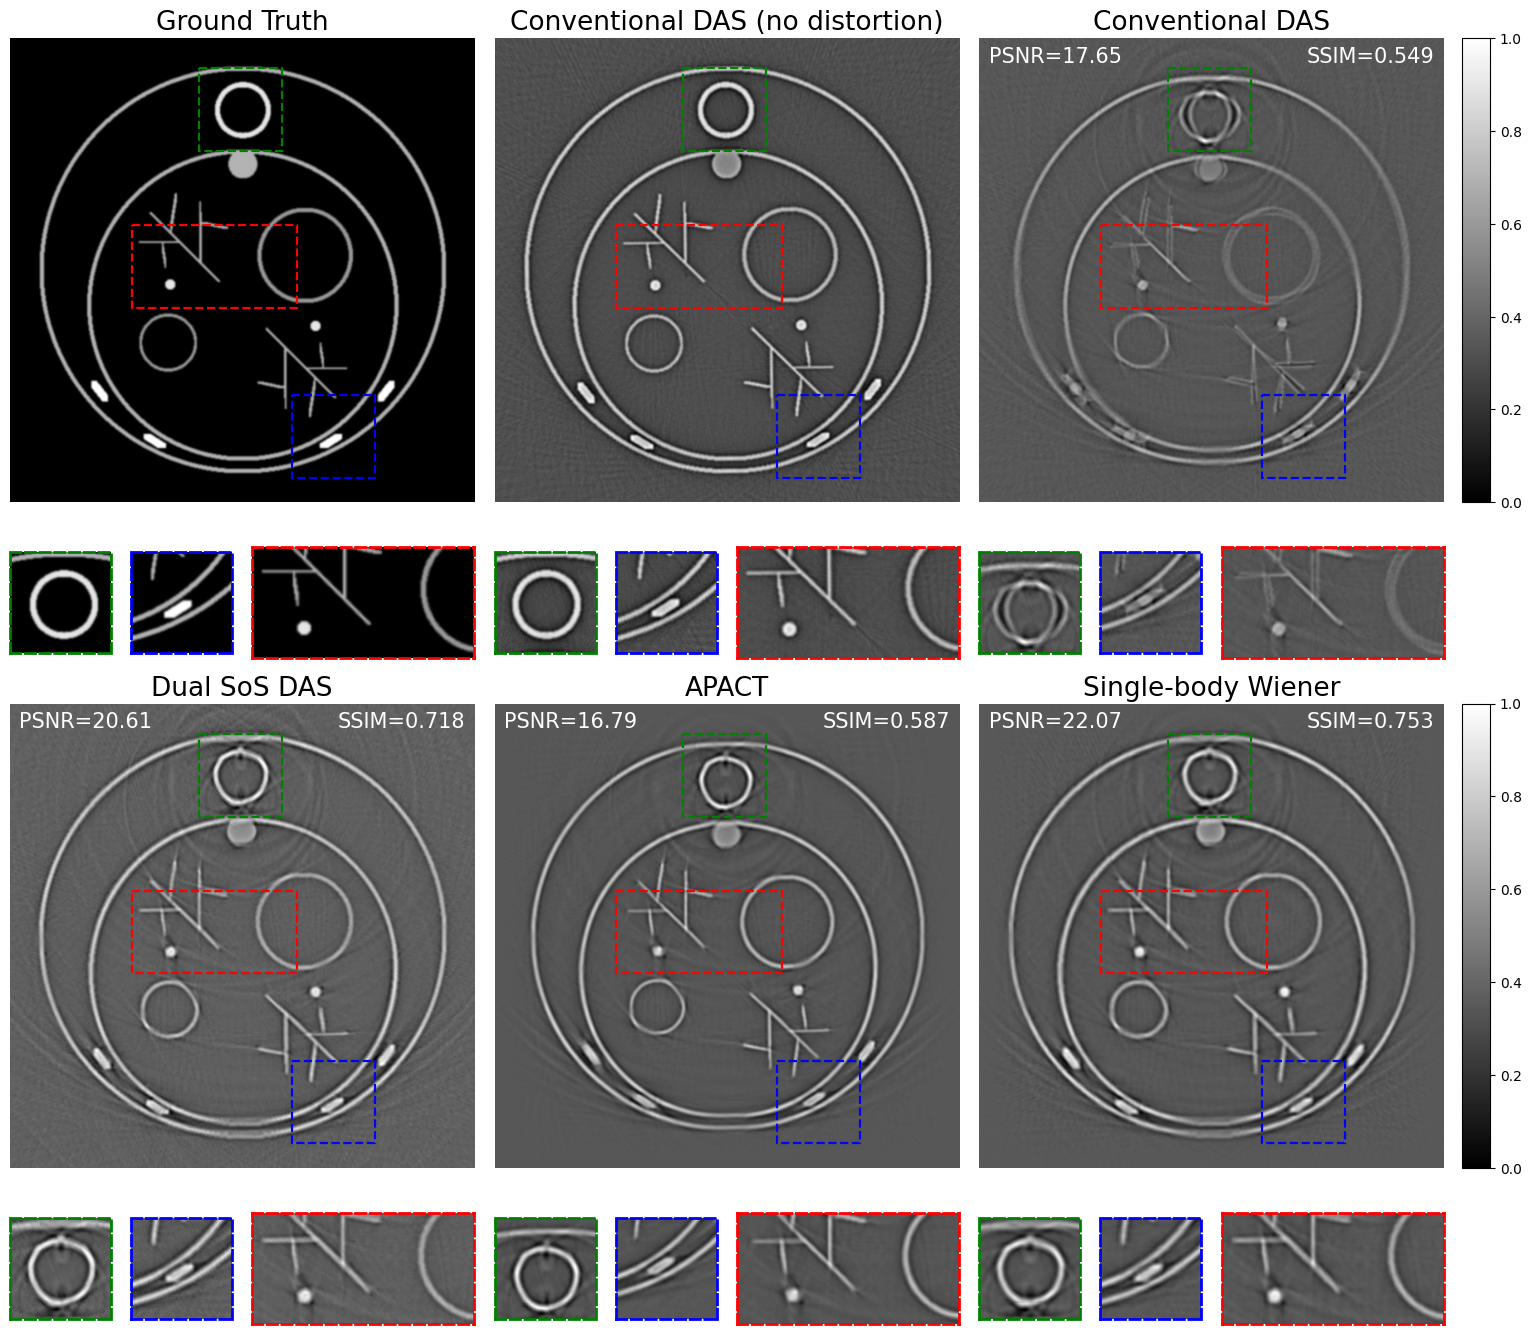

In [28]:
patches = [(36, 227, 100, 100, 'green'), (430, 340, 100, 100,'blue'), (225, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
norm = matplotlib.colors.Normalize(vmax=1, vmin=0)
for idx, (rec_full, method) in enumerate(zip([IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_wiener], ['Ground Truth', 'Conventional DAS (no distortion)', 'Conventional DAS', 'Dual SoS DAS', 'APACT', 'Single-body Wiener'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 1:
        plt.title('PSNR={:.2f}'.format(psnr(gt, rec_full, data_range=1)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(gt, rec_full, data_range=1)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

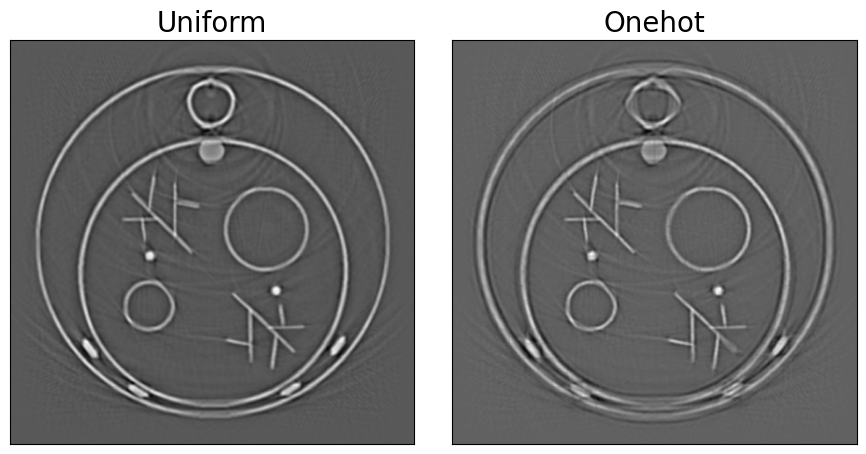

In [29]:
fig = plt.figure(figsize=(9, 4.5))
for idx, (rec_full, attention) in enumerate(zip([rec_wiener, rec_wiener_onehot], ['Uniform', 'Onehot'])):
        ax = plt.subplot(1,2,idx+1)
        plt.imshow(rec_full, cmap='gray', norm=norm)
        plt.title(attention, fontsize=20)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()

In [ ]:
# fig = plt.figure(figsize=(16, 10))
# for i, attention in enumerate(['uniform', 'euclidean', 'onehot']):
#     for j, mode in enumerate(['uniform', 'quadric']):
#         ax = plt.subplot(2,3,j*3+i+1)
#         delays = get_delays(R, v0, v1, n_delays, mode)
#         rec_full = deconv_full_sb(wiener, img_stack, psfs, gaussian_window, delays, attention=attention)
#         rec_full = normalize(rec_full)
#         plt.imshow(rec_full, cmap='gray', norm=norm)
#         if j == 0:
#             plt.title(attention, fontsize=20)
#         if i == 0:
#             plt.ylabel(mode, fontsize=20)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout()